## Supplementary Figure 6

Select MOA compound level 5 heatmaps

In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))

source("viz_themes.R")
source("plotting_functions.R")
source("data_functions.R")

In [2]:
output_figure_base <- file.path("figures", "supplementary", "supfigure6")
extensions <- c(".png", ".pdf")

In [3]:
# Load profiles for heatmap prep
results_dir <- file.path("../1.Data-exploration/Consensus/")

cell_painting_profile_file <- file.path(
    results_dir, "cell_painting", "moa_sizes_consensus_datasets",
    "cell_painting_moa_analytical_set_profiles.tsv.gz"
)
l1000_profile_file <- file.path(
    results_dir, "L1000", "moa_sizes_consensus_datasets",
    "l1000_moa_analytical_set_profiles.tsv.gz"
)

cp_profile_cols <- readr::cols(
    .default = readr::col_double(),
    Metadata_Plate_Map_Name = readr::col_character(),
    Metadata_cell_id = readr::col_character(),
    Metadata_broad_sample = readr::col_character(),
    Metadata_pert_well = readr::col_character(),
    Metadata_time_point = readr::col_character(),
    Metadata_moa = readr::col_character(),
    Metadata_target = readr::col_character(),
    broad_id = readr::col_character(),
    pert_iname = readr::col_character(),
    moa = readr::col_character()
)

l1000_profile_cols <- readr::cols(
    .default = readr::col_double(),
    sig_id = readr::col_character(),
    pert_id = readr::col_character(),
    pert_idose = readr::col_character(),
    pert_iname = readr::col_character(),
    moa = readr::col_character()
)

cp_profile_df <- readr::read_tsv(cell_painting_profile_file, col_types = cp_profile_cols)
cp_profile_df$Metadata_dose_recode <- dplyr::recode(paste(cp_profile_df$Metadata_dose_recode), !!!dose_rename)
cp_profile_df$Metadata_dose_recode <- factor(cp_profile_df$Metadata_dose_recode, levels = dose_order)

l1000_profile_df <- readr::read_tsv(l1000_profile_file, col_types = l1000_profile_cols) %>%
    rename(Metadata_dose_recode = dose)
l1000_profile_df$Metadata_dose_recode <- dplyr::recode(paste(l1000_profile_df$Metadata_dose_recode), !!!dose_rename)
l1000_profile_df$Metadata_dose_recode <- factor(l1000_profile_df$Metadata_dose_recode, levels = dose_order)

common_perts <- intersect(
    unique(cp_profile_df$pert_iname),
    unique(l1000_profile_df$pert_iname)
)

cp_profile_df <- cp_profile_df %>% dplyr::filter(pert_iname %in% !!common_perts)
l1000_profile_df <- l1000_profile_df %>% dplyr::filter(pert_iname %in% !!common_perts)

In [4]:
length(unique(cp_profile_df$moa))
length(unique(l1000_profile_df$moa))

[1] 211

[1] 211

In [5]:
# Load percent matching scores
results_dir <- file.path("../1.Data-exploration/Consensus/")

pm_cellpainting_list <- load_percent_matching(assay = "cellpainting", results_dir = results_dir)
pm_l1000_list <- load_percent_matching(assay = "l1000", results_dir = results_dir)

p_val_alpha_thresh <- 0.05
no_replicates_thresh <- 3

cell_painting_pm_df <- pm_cellpainting_list[["percent_matching"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)
l1000_pm_df <- pm_l1000_list[["percent_matching"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)

pm_df <- dplyr::bind_rows(cell_painting_pm_df, l1000_pm_df)

cell_painting_pm_pval_df <- pm_cellpainting_list[["percent_matching_pvals"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)
l1000_pm_pval_df <- pm_l1000_list[["percent_matching_pvals"]] %>%
    dplyr::filter(no_of_replicates >= no_replicates_thresh)

pm_pval_df <- dplyr::bind_rows(cell_painting_pm_pval_df, l1000_pm_pval_df)

pm_df <- pm_df %>%
    dplyr::left_join(pm_pval_df, by = c("moa", "dose", "assay", "no_of_replicates")) %>%
    dplyr::mutate(pass_thresh = p_value < p_val_alpha_thresh) %>%
    dplyr::mutate(neg_log_10_p_val = -log10(p_value))

pm_df$dose <- factor(pm_df$dose, levels = dose_order)

pm_df$neg_log_10_p_val[pm_df$neg_log_10_p_val == Inf] = 3.5

print(dim(pm_df))
head(pm_df)

[1] 1524    8


moa,no_of_replicates,dose,matching_score,assay,p_value,pass_thresh,neg_log_10_p_val
<chr>,<dbl>,<fct>,<dbl>,<chr>,<dbl>,<lgl>,<dbl>
acat inhibitor,3,0.04 uM,0.004444607,Cell Painting,0.513,FALSE,0.2898826
acetylcholine receptor agonist,8,0.04 uM,0.005142343,Cell Painting,0.576,FALSE,0.2395775
acetylcholine receptor antagonist,21,0.04 uM,0.019262183,Cell Painting,0.017,TRUE,1.7695511
adenosine receptor agonist,3,0.04 uM,0.009583710,Cell Painting,0.442,FALSE,0.3545777
adenosine receptor antagonist,4,0.04 uM,0.001703919,Cell Painting,0.612,FALSE,0.2132486
adrenergic receptor agonist,20,0.04 uM,0.005015938,Cell Painting,0.683,FALSE,0.1655793


In [6]:
# Which MOAs are objectively the most differential performing
compare_pm_df <- pm_df %>%
    reshape2::dcast(moa + no_of_replicates + dose ~ assay, value.var = "matching_score") %>%
    dplyr::mutate(
        assay_diff = `Cell Painting` - L1000,
        cp_higher_pm = `Cell Painting` > L1000,
        l1000_higher_pm = `Cell Painting` <= L1000
    ) %>%
    dplyr::group_by(moa) %>%
    dplyr::summarize(
        total_cp_better = sum(cp_higher_pm),
        total_l1000_better = sum(l1000_higher_pm),
        total_assay_diff = sum(assay_diff),
        mean_assay_diff = mean(assay_diff),
        num_replicates = mean(no_of_replicates)
    ) %>%
    dplyr::mutate(
        abs_diff = abs(total_assay_diff),
        mean_abs_diff = abs(mean_assay_diff)
    ) %>%
    dplyr::arrange(desc(abs_diff))

head(compare_pm_df, 5)

moa,total_cp_better,total_l1000_better,total_assay_diff,mean_assay_diff,num_replicates,abs_diff,mean_abs_diff
<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
plk inhibitor,6,0,1.5824042,0.2637340,4,1.5824042,0.2637340
hsp inhibitor,1,5,-1.1988002,-0.1998000,5,1.1988002,0.1998000
mtor inhibitor|pi3k inhibitor,2,4,-1.0290862,-0.1715144,4,1.0290862,0.1715144
hdac inhibitor,0,6,-0.8697068,-0.1449511,13,0.8697068,0.1449511
mek inhibitor,0,6,-0.8648843,-0.1441474,8,0.8648843,0.1441474


In [7]:
target_moa <- "mek inhibitor"
corr_compare_plot_ready <- get_subset_correlation_data(cp_profile_df, l1000_profile_df, target_moa)
compound_a_gg <- plot_correlation_data(corr_compare_plot_ready, target_moa, fix_coords = FALSE)

In [8]:
target_moa <- "plk inhibitor"
corr_compare_plot_ready <- get_subset_correlation_data(cp_profile_df, l1000_profile_df, target_moa)
compound_b_gg <- plot_correlation_data(corr_compare_plot_ready, target_moa, fix_coords = FALSE)

In [9]:
target_moa <- "estrogen receptor agonist"
corr_compare_plot_ready <- get_subset_correlation_data(cp_profile_df, l1000_profile_df, target_moa)
compound_c_gg <- plot_correlation_data(corr_compare_plot_ready, target_moa, fix_coords = FALSE)

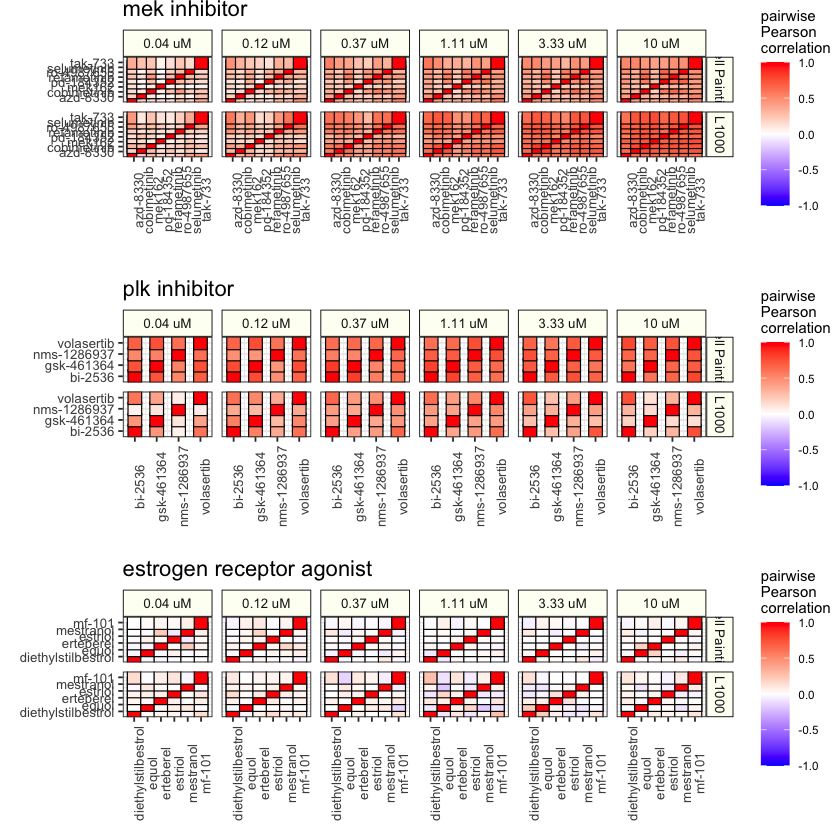

In [10]:
supfig4_gg <- cowplot::plot_grid(
    compound_a_gg + theme(plot.margin = unit(c(0, 0, 0, 0), "cm")),
    compound_b_gg + theme(plot.margin = unit(c(0, 0, 0, 0), "cm")),
    compound_c_gg + theme(plot.margin = unit(c(0, 0, 0, 0), "cm")),   
    nrow = 3,
    align = "hv"
)

supfig4_gg

In [11]:
for (extension in extensions) {
    output_file <- paste0(output_figure_base, extension)
    cowplot::save_plot(output_file, supfig4_gg, base_width = 11, base_height = 13, dpi = 500)
}